In [1]:
# import the required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import random

Dataset Link - https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation

In [2]:
def read_and_normalize(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (512, 512))
    img = np.array(img, dtype='float32')
    img = img/255 # Normalization
    return img

In [3]:
X_train = [] # To store images
y_train = [] # To store labels

# labels -
# 0 - Covid
# 1 - Viral Pneumonia
# 2 - Normal

covid_path = "../input/covid19-image-dataset/Covid19-dataset/train/Covid/"

for entry in os.scandir(covid_path):
    X_train.append(read_and_normalize(covid_path + entry.name))
    y_train.append(0)

In [4]:
covid_test_count = len(X_train)
covid_test_count

111

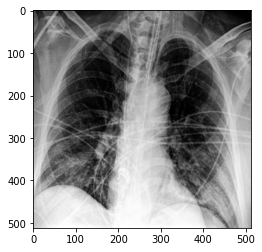

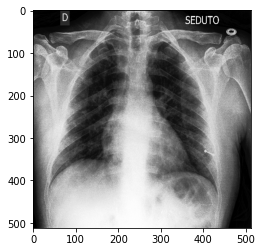

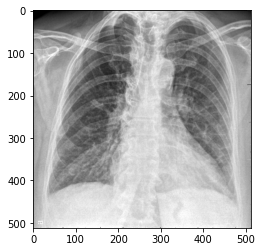

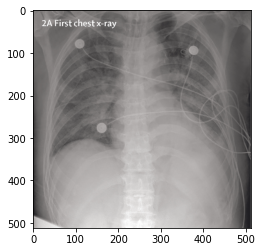

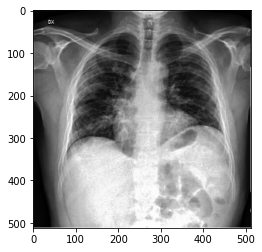

In [5]:
for i in range(0,5):
    plt.figure()
    plt.imshow(X_train[i])

In [6]:
pneumonia_path = "../input/covid19-image-dataset/Covid19-dataset/train/Viral Pneumonia/"

for entry in os.scandir(pneumonia_path):
    X_train.append(read_and_normalize(pneumonia_path + entry.name))
    y_train.append(1)

In [7]:
pneumonia_test_count = len(X_train)-covid_test_count

In [8]:
pneumonia_test_count

70

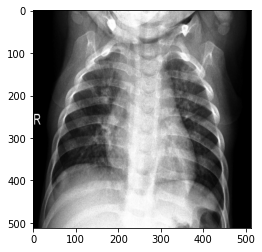

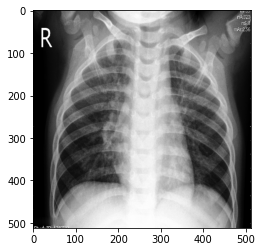

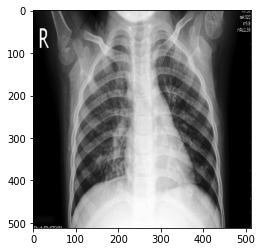

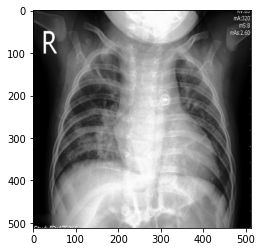

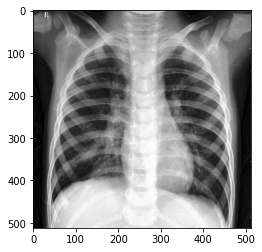

In [9]:
for i in range(111, 116):
    plt.figure()
    plt.imshow(X_train[i])

In [10]:
normal_path = "../input/covid19-image-dataset/Covid19-dataset/train/Normal/"

for entry in os.scandir(normal_path):
    X_train.append(read_and_normalize(normal_path + entry.name))
    y_train.append(2)

In [11]:
normal_test_count = len(X_train)-covid_test_count-pneumonia_test_count
normal_test_count

70

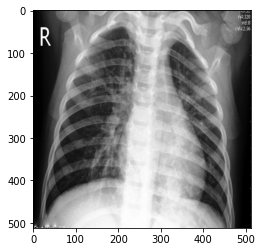

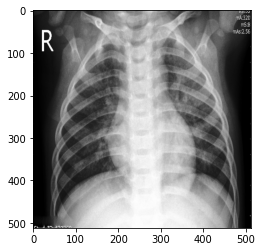

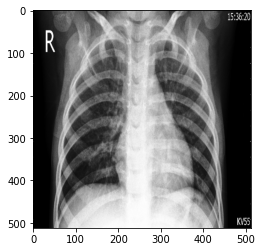

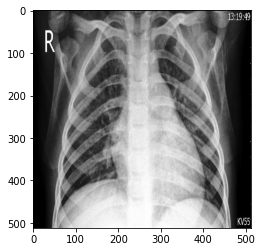

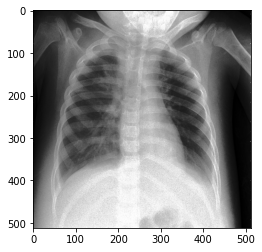

In [12]:
for i in range(171, 176):
    plt.figure()
    plt.imshow(X_train[i])

In [13]:
X_train = np.array(X_train)
X_train.shape

(251, 512, 512, 3)

In [14]:
y_train = np.array(y_train)
y_train.shape

(251,)

In [15]:
y = np.zeros((251, 3))
y[np.arange(y_train.size),y_train] = 1

In [16]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

## DATA VISUALISATION

In [17]:
from sklearn.model_selection import train_test_split

In [19]:
# split the data into train and test data

X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size = 0.15, shuffle=True)

In [20]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(512, 512, 3)))

94773248/94765736 [==============================] - 1s 0us/step


In [21]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [22]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [23]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(3, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [25]:
# compile the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [26]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [27]:
history = model.fit(X_train, y_train, epochs = 20, validation_data=(X_val, y_val), callbacks=[checkpointer, earlystopping])

Epoch 1/20
7/7 [==============================] - 22s 1s/step - loss: 4.8650 - accuracy: 0.4647 - val_loss: 4621.8413 - val_accuracy: 0.4474

Epoch 00001: val_loss improved from inf to 4621.84131, saving model to classifier-resnet-weights.hdf5
Epoch 2/20
7/7 [==============================] - 5s 789ms/step - loss: 0.6127 - accuracy: 0.7840 - val_loss: 30603.8027 - val_accuracy: 0.4474

Epoch 00002: val_loss did not improve from 4621.84131
Epoch 3/20
7/7 [==============================] - 5s 786ms/step - loss: 0.3625 - accuracy: 0.8457 - val_loss: 144727.6094 - val_accuracy: 0.4474

Epoch 00003: val_loss did not improve from 4621.84131
Epoch 4/20
7/7 [==============================] - 5s 787ms/step - loss: 0.2249 - accuracy: 0.9285 - val_loss: 51393.0742 - val_accuracy: 0.4474

Epoch 00004: val_loss did not improve from 4621.84131
Epoch 5/20
7/7 [==============================] - 6s 786ms/step - loss: 0.2475 - accuracy: 0.9084 - val_loss: 16382.6084 - val_accuracy: 0.4474

Epoch 00005: 

In [28]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [29]:
# Load pretrained model 
with open('classifier-resnet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('classifier-resnet-weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [30]:
X_test = [] # To store images
y_test = [] # To store labels

# labels -
# 0 - Covid
# 1 - Viral Pneumonia
# 2 - Normal

covid_path = "../input/covid19-image-dataset/Covid19-dataset/test/Covid/"

for entry in os.scandir(covid_path):
    X_test.append(read_and_normalize(covid_path + entry.name))
    y_test.append(0)

In [31]:
covid_path = "../input/covid19-image-dataset/Covid19-dataset/test/Viral Pneumonia/"

for entry in os.scandir(covid_path):
    X_test.append(read_and_normalize(covid_path + entry.name))
    y_test.append(1)

In [32]:
covid_path = "../input/covid19-image-dataset/Covid19-dataset/test/Normal/"

for entry in os.scandir(covid_path):
    X_test.append(read_and_normalize(covid_path + entry.name))
    y_test.append(2)

In [33]:
X_test = np.array(X_test)
X_test.shape

(66, 512, 512, 3)

In [34]:
predictions = model.predict(X_test)

In [35]:
predictions.shape

(66, 3)

In [39]:
predictions

array([[0.3983281 , 0.29216516, 0.3095068 ],
       [0.40930662, 0.28738052, 0.30331284],
       [0.41470218, 0.28452706, 0.30077076],
       [0.40552843, 0.28864837, 0.3058232 ],
       [0.40079403, 0.29055515, 0.30865076],
       [0.4167467 , 0.28389135, 0.29936188],
       [0.41613188, 0.2840792 , 0.29978892],
       [0.39987826, 0.29114348, 0.30897823],
       [0.41159362, 0.28617194, 0.30223444],
       [0.40230677, 0.29036656, 0.30732667],
       [0.4015218 , 0.2907185 , 0.3077597 ],
       [0.40677685, 0.28751525, 0.30570796],
       [0.3938686 , 0.29374072, 0.31239069],
       [0.39613438, 0.29291573, 0.31094983],
       [0.41606903, 0.2839199 , 0.30001107],
       [0.40552843, 0.28864837, 0.3058232 ],
       [0.4102408 , 0.28650016, 0.30325904],
       [0.4017824 , 0.29013935, 0.30807826],
       [0.3981514 , 0.29209232, 0.30975625],
       [0.4147132 , 0.2848256 , 0.30046117],
       [0.4050034 , 0.28922692, 0.30576968],
       [0.405355  , 0.288957  , 0.30568796],
       [0.

In [36]:
# Obtain the predicted class from the model prediction
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

In [37]:
predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [38]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
accuracy

0.3939393939393939

In [39]:
set(predict)

{0}

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

We have managed to get an accuracy of 95% with a good balance between Precision and Recall.